In [1]:
import matplotlib.pyplot as plt
import mpl_lego as mplego
import numpy as np
import pandas as pd

from scipy.stats import mannwhitneyu

from hatespeech import utils
from hatespeech.keys import items, annotator_race_to_col
from mpl_lego.colorbar import append_colorbar_to_axis

%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
#data_path = '/home/psachdeva/data/scaled-facets-multi-50k-v4.feather'
data_path = '~/data/hatespeech/scaled-facets-multi-50k-v4.feather'

In [4]:
data = pd.read_feather(data_path).rename(columns={'violence_phys': 'violence'})

In [5]:
reference_set = data[data['platform'] == 'reference'].copy()

In [6]:
print(f'Number of unique reference set comments: {reference_set["comment_id"].unique().size}')
print(f'Number of samples in reference set: {reference_set.shape[0]}')

Number of unique reference set comments: 70
Number of samples in reference set: 43227


In [7]:
reference_bw = reference_set[
    (reference_set[annotator_race_to_col['black']] == 1) | 
    (reference_set[annotator_race_to_col['white']] == 1)
]
reference_bw = utils.filter_comments_targeting_bw(reference_bw, threshold=0.5)

In [8]:
reference_bw_targeting_b = reference_bw[reference_bw['target_black']].copy()
reference_bw_targeting_w = reference_bw[~reference_bw['target_black']].copy()

In [9]:
print(f'Number of samples whose annotators are black or white: {reference_bw.shape[0]}')
print(f'Number of samples targeting black identity whose annotators are black or white: {reference_bw_targeting_b.shape[0]}')
print(f'Number of samples targeting white identity whose annotators are black or white: {reference_bw_targeting_w.shape[0]}')
print(f'Number of unique comments targeting black people: {reference_bw_targeting_b["comment_id"].unique().size}')
print(f'Number of unique comments targeting white people: {reference_bw_targeting_w["comment_id"].unique().size}')

Number of samples whose annotators are black or white: 10777
Number of samples targeting black identity whose annotators are black or white: 9776
Number of samples targeting white identity whose annotators are black or white: 1001
Number of unique comments targeting black people: 18
Number of unique comments targeting white people: 2


In [10]:
reference_bw_targeting_b['annotator_race'] = np.where(
    reference_bw_targeting_b[annotator_race_to_col['black']] == 1,
    'black',
    'white')
reference_bw_targeting_w['annotator_race'] = np.where(
    reference_bw_targeting_w[annotator_race_to_col['black']] == 1,
    'black',
    'white')

In [11]:
bw_targeting_b_comments = np.sort(reference_bw_targeting_b['comment_id'].unique())
bw_targeting_b_counts = reference_bw_targeting_b.groupby(['comment_id', 'annotator_race']).count()
bw_targeting_b_means = reference_bw_targeting_b.groupby(['comment_id', 'annotator_race']).mean()[items]
bw_targeting_b_diffs = bw_targeting_b_means.diff().query("annotator_race == 'white'").droplevel('annotator_race')

In [12]:
p_values = np.zeros((bw_targeting_b_comments.size, len(items)))

for ii, comment_id in enumerate(bw_targeting_b_comments):
    for jj, item in enumerate(items):
        black_scores = reference_bw_targeting_b[
            (reference_bw_targeting_b['comment_id'] == comment_id) &
            (reference_bw_targeting_b['annotator_race'] == 'black')
        ][item]
        white_scores = reference_bw_targeting_b[
            (reference_bw_targeting_b['comment_id'] == comment_id) &
            (reference_bw_targeting_b['annotator_race'] == 'white')
        ][item]

        try:
            p_values[ii, jj] = mannwhitneyu(black_scores, white_scores).pvalue
        except:
            p_values[ii, jj] = 1
        
p_values = pd.DataFrame(data=p_values, columns=items, index=bw_targeting_b_comments)

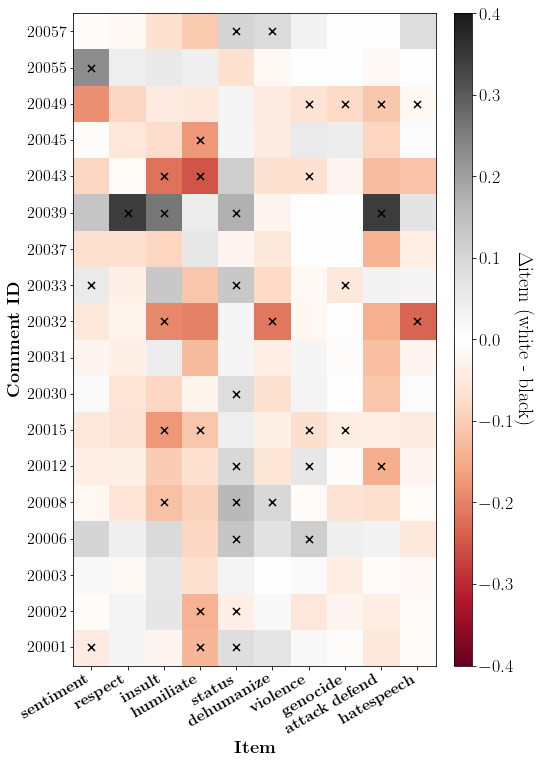

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9, 12))

img = ax.imshow(bw_targeting_b_diffs, vmin=-0.4, vmax=0.4, cmap='RdGy')
cb, cax = append_colorbar_to_axis(ax, img)
cb.set_label(r'$\Delta$item (white - black)', rotation=270, fontsize=20, labelpad=20)
cb.ax.tick_params(labelsize=18)

for ii in range(p_values.shape[0]):
    for jj in range(p_values.shape[1]):
        if p_values.iloc[ii, jj] < 0.05:
            ax.scatter(jj, ii, marker='x', color='black', s=50)
            
ax.set_xticks(np.arange(len(items)))
ax.set_xticklabels(mplego.labels.bold_text(mplego.labels.fix_labels_for_tex_style(items)), rotation=30, ha='right')
ax.set_yticks(np.arange(len(bw_targeting_b_diffs)))
ax.set_yticklabels(bw_targeting_b_diffs.index)
ax.set_ylabel(r'\textbf{Comment ID}', fontsize=18)
ax.set_xlabel(r'\textbf{Item}', fontsize=18)
ax.tick_params(labelsize=16)
plt.savefig('black_v_white_comment_comparison.pdf', bbox_inches='tight')
plt.show()

In [ ]:
comments_w_diffs = pd.concat(
    [reference_bw_targeting_b[reference_bw_targeting_b['comment_id'].isin(bw_targeting_b_comments)][['comment_id', 'predict_text']].sort_values('comment_id').drop_duplicates().reset_index(drop=True),
     (p_values < 0.05).reset_index(drop=True).add_suffix('_sig'),
     bw_targeting_b_diffs.reset_index(drop=True).add_suffix('_diff')],
    axis=1)

In [ ]:
comments_w_diffs.to_csv('black_v_white_comments.csv')